In [6]:
# Necessary Imports
from astropy.constants import c
from astropy import units as u
import numpy as np
from astropy.modeling.models import Voigt1D
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
from astropy.io import fits
from scipy.signal import find_peaks
from astropy.modeling import models, fitting
import math
from scipy.optimize import curve_fit

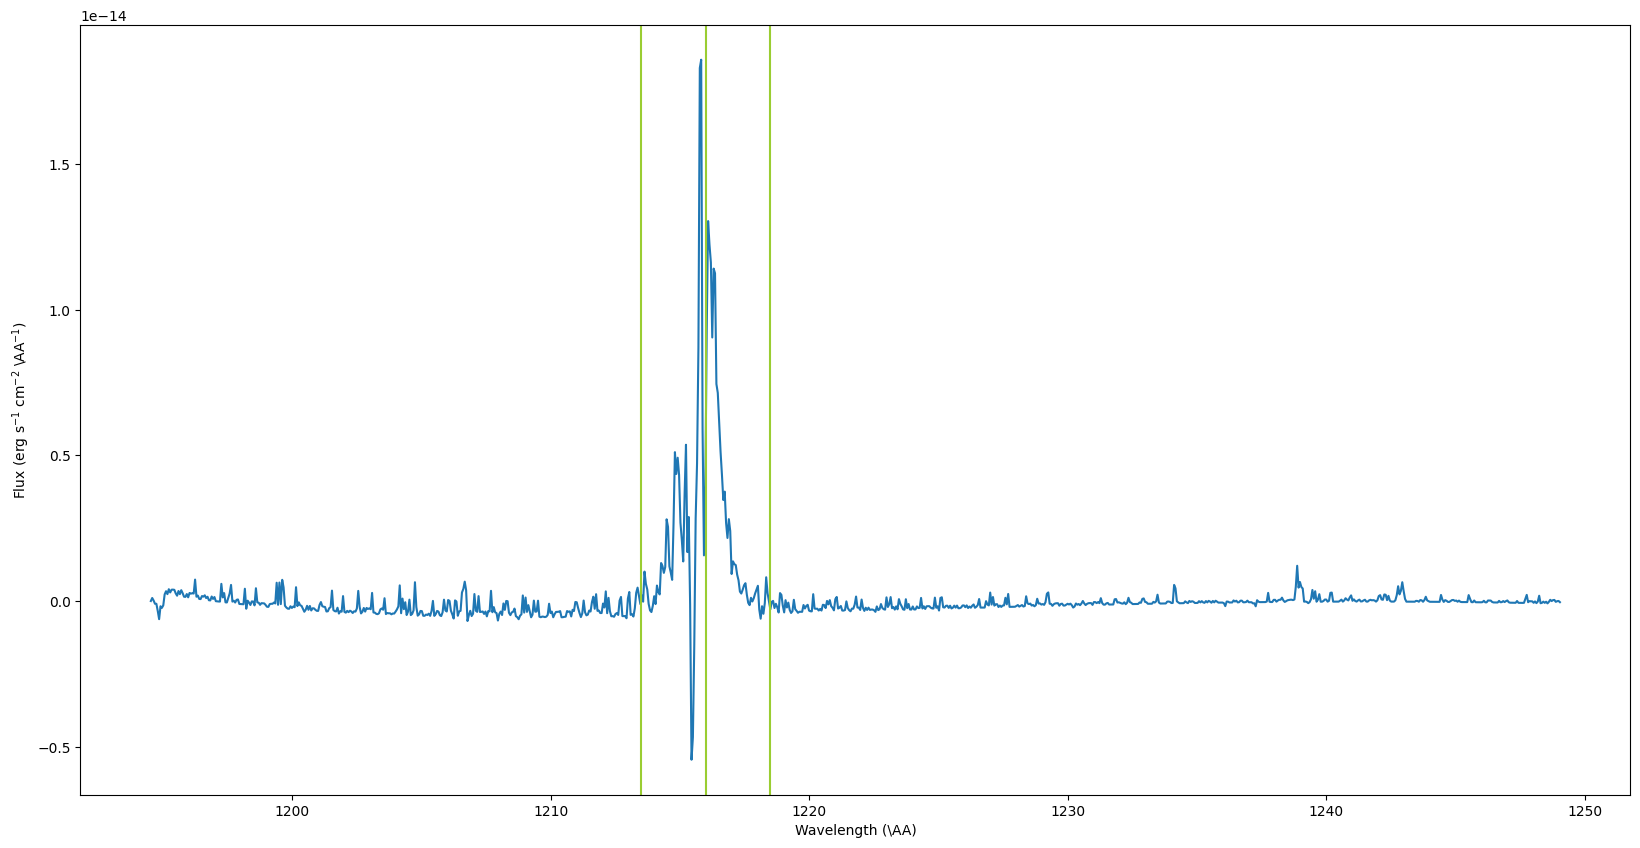

In [67]:
# Pull the spectra data
data = fits.getdata('hlsp_space_hst_stis_toi-1201_g140m_v1_component-spec.fits')
w, f , e, dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
mask = (w > 1160) 
plt.figure(figsize=(,10))

plt.plot(w[mask], f[mask])

# Find the start/end of the line
center = 1216
line_start = center - 2.5
line_end = center + 2.5
plt.axvline(x = center, color = 'yellowgreen', label = 'axvline - full height')
plt.axvline(x = line_start, color = 'yellowgreen', label = 'axvline - full height')
plt.axvline(x = line_end, color = 'yellowgreen', label = 'axvline - full height')


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.show()

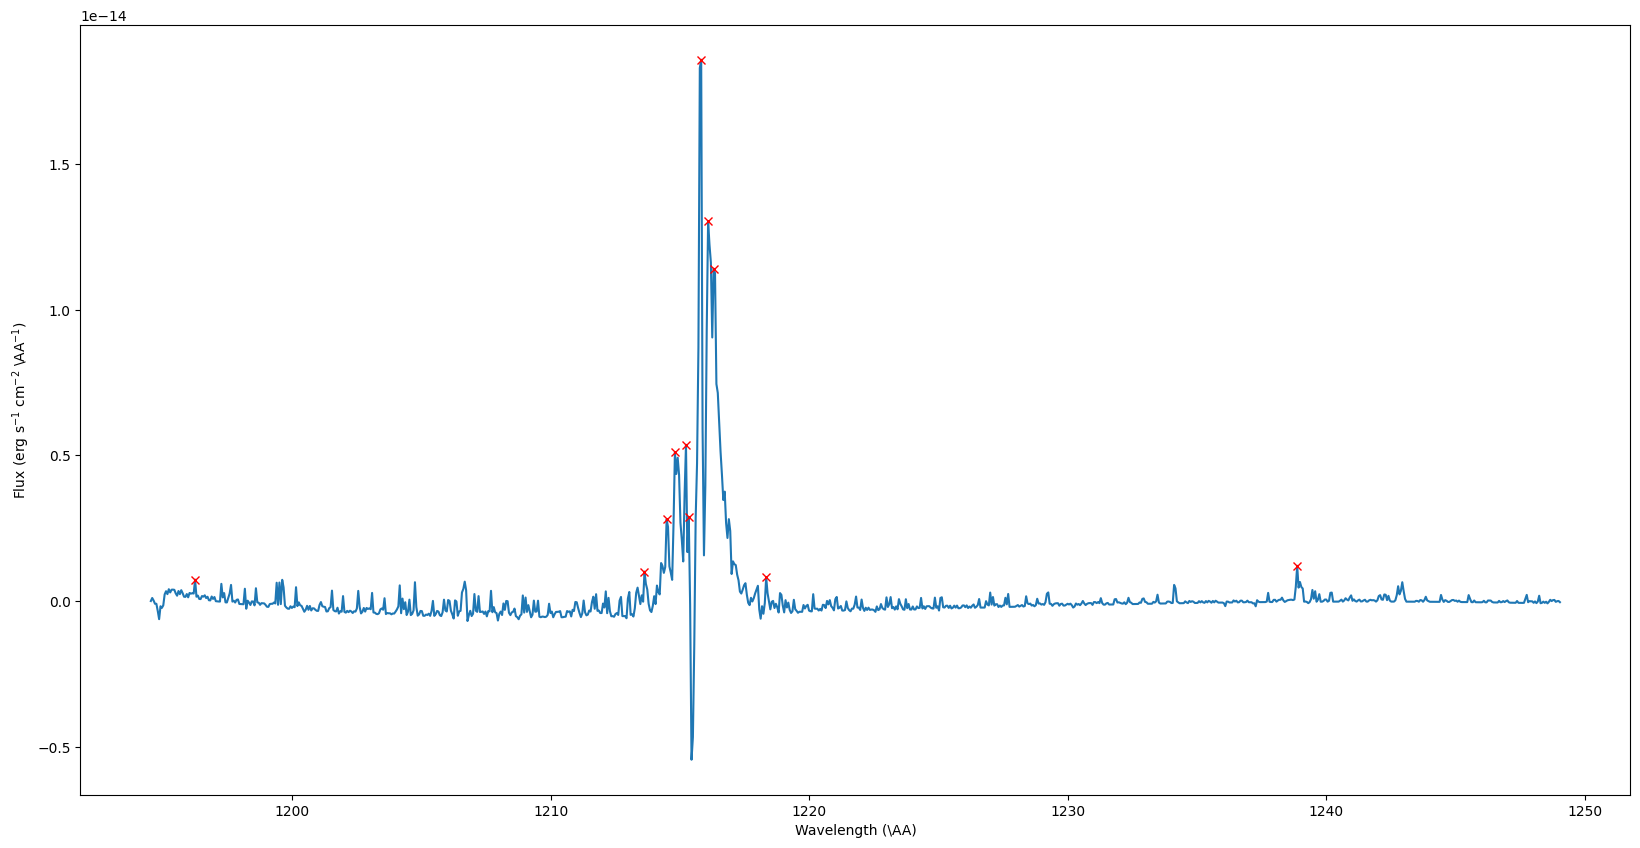

Peak 0: 1196.247072331785
Peak 1: 1213.6296035472653
Peak 2: 1214.4853589301813
Peak 3: 1214.8062671987748
Peak 4: 1215.2341448902328
Peak 5: 1215.3411143130973
Peak 6: 1215.8224767159875
Peak 7: 1216.0899002731487
Peak 8: 1216.3038391188777
Peak 9: 1218.336258153303
Peak 10: 1238.8743873432861


In [8]:
# Find peaks
peaks, properties  = find_peaks(f[mask], height = 5*sum(f[mask])/len(f[mask]), prominence = 5*sum(f[mask])/len(f[mask]), width = 0, threshold = (1/5)*sum(f[mask])/len(f[mask]))

plt.figure(figsize=(20,10))
plt.plot(w[mask], f[mask])
plt.plot(w[mask][peaks], f[mask][peaks], "xr")
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.show()

# All peaks!
count = 0
for peak in w[mask][peaks]:
    print(f"Peak {count}: {peak}")
    count+=1

In [9]:
# Get rest data
data = pd.read_csv("DEM_goodlinelist .csv")
df = pd.DataFrame(data)
# df = df[df["Likelihood to measure"] == "High"]
print(df)

       Ion  Wavelength Likelihood to measure  Log Formation Temperature
0     S VI     933.397                Medium                        5.3
1    N III     989.787                Medium                        4.9
2    N III     991.495                Medium                        4.9
3    N III     991.564                Medium                        4.9
4    Ne VI     999.182                Medium                        5.6
5     O VI    1032.914                Medium                        5.5
6     O VI    1037.615                Medium                        5.5
7   Fe XIX    1118.057                   Low                        6.9
8     Ne V    1145.596                Medium                        5.5
9    C III    1174.935                  High                        4.9
10   C III    1175.265                  High                        4.9
11   C III    1175.592                  High                        4.9
12   C III    1175.713                  High                    

(1200.0, 1250.0)

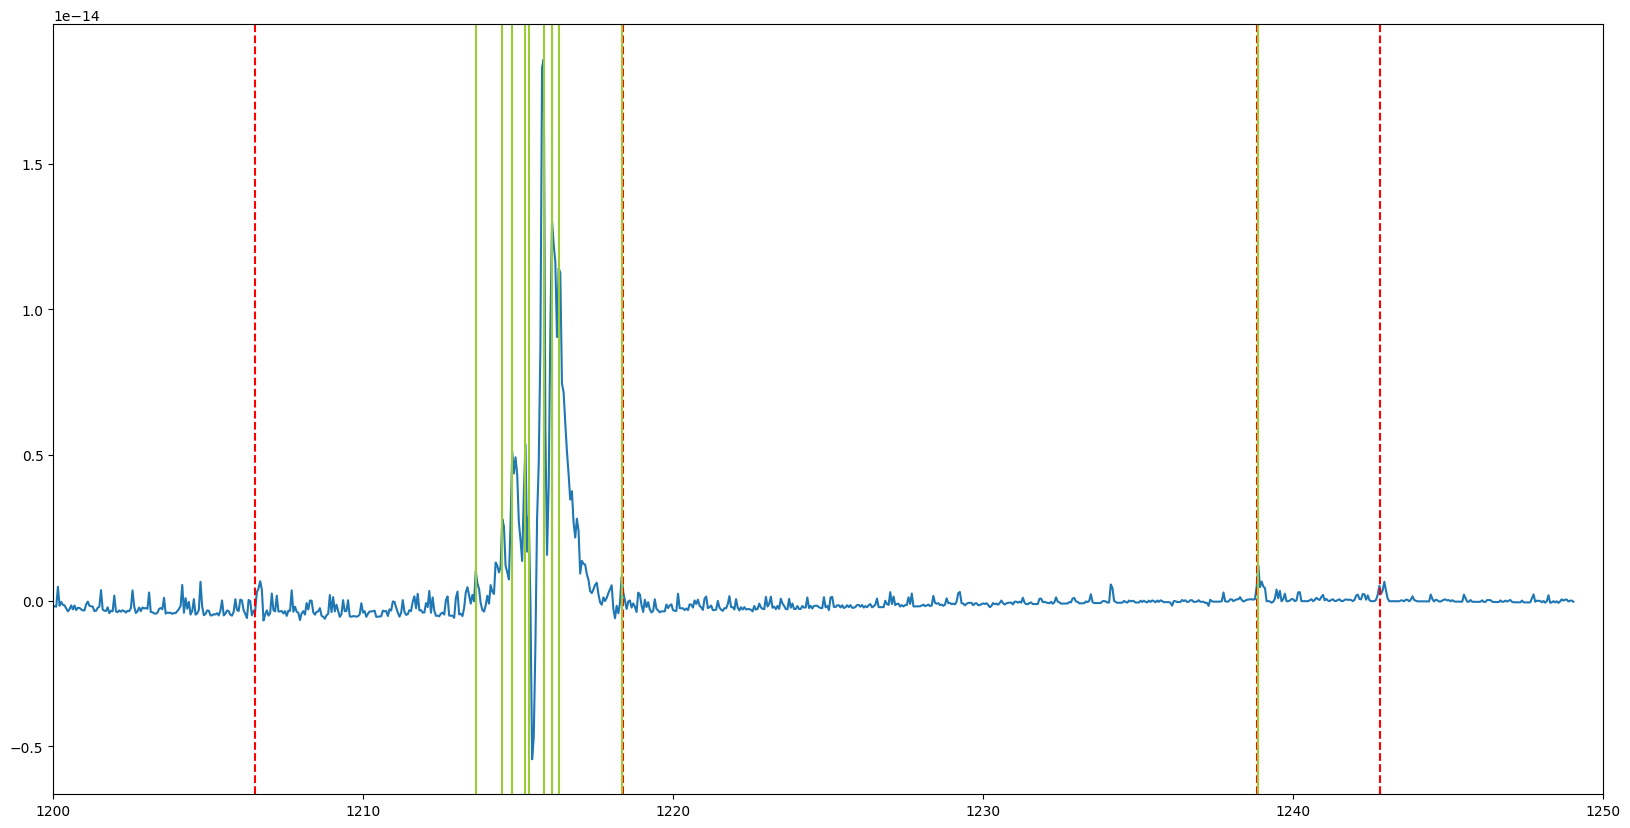

In [10]:
# Do backwork for calculating the radial velocity
fig, ax = plt.subplots()
ax.plot(w[mask], f[mask])
fig.set_figheight(10)
fig.set_figwidth(20) 

for line in df['Wavelength']:
    if(line > 1160):
        plt.axvline(x = line, color = 'red', label = 'axvline - full height', linestyle = "--")
    
for peak in w[mask][peaks]:
    plt.axvline(x = peak, color = 'yellowgreen', label = 'axvline - full height')

plt.xlim([1200, 1250]) # add +50

In [11]:
# Calculate the radial velocity

observed_wavelength = 1238.8743873432861 * u.Angstrom
rest_wavelength = 1238.821 * u.Angstrom

# Calculate the doppler shift
delta_lambda = observed_wavelength - rest_wavelength

# Calculate the radial velocity
radial_velocity = (delta_lambda / rest_wavelength) * c

print(f"Radial Velocity: {radial_velocity.to(u.km/u.s)}")



Radial Velocity: 12.919641231348859 km / s


In [12]:
# Calculate the amplitude of the emission line

# Find indices corresponding to the line region in the spectrum
line_indices = np.where((w >= line_start) & (w <= line_end))

# Find the continuum
continuum_left = np.where(w < line_start)
continuum_right = np.where(w > line_end)
continuum = np.mean(np.concatenate((f[continuum_left], f[continuum_right])))

# Calculate the amplitude of the emission line
line_amplitude = np.max(f[line_indices]) - continuum

print(f"Amplitude of the emission line: {line_amplitude}")
print(f"Log of the ampltiude of the emission line: {math.log(line_amplitude, 10)}")



Amplitude of the emission line: 1.8682737015565815e-14
Log of the ampltiude of the emission line: -13.72855949942911


In [26]:
# Calculate the FWHM
def fwhm_wavelength(w, f):

    # Find the index of the maximum intensity value
    max_index = np.argmax(f)
    max_intensity = f[max_index]

    # Find the positions on the wavelength axis where intensity is half of the maximum
    half_max_intensity = max_intensity / 2
    left_index = np.argmin(np.abs(f[:max_index] - half_max_intensity))
    right_index = np.argmin(np.abs(f[max_index:] - half_max_intensity)) + max_index

    # Calculate the FWHM in wavelength
    fwhm_wavelength_value = w[right_index] - w[left_index]

    return fwhm_wavelength_value

Mean of the Gaussian: 2.0959444997286443e-15
Standard Deviation of the Gaussian: 3.423458247082287e-15


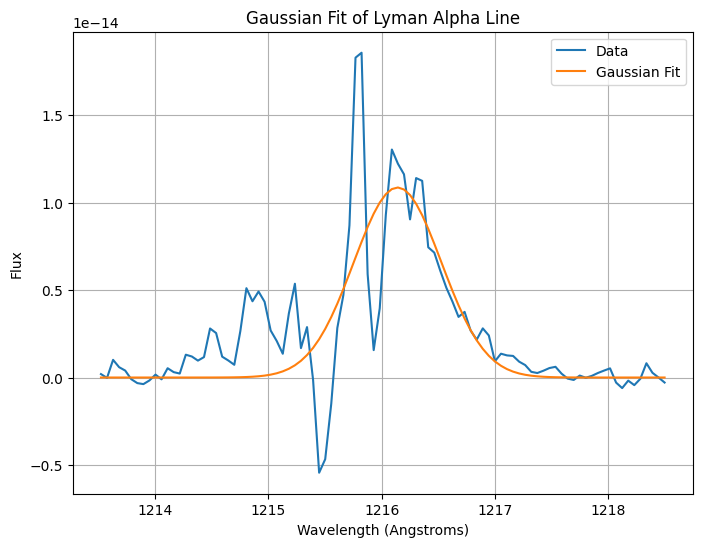

FWHM of the Gaussian: 0.9092400943482062 Angstroms


In [57]:
# GAUSSIAN FIT

# Mask current peak (use this for the rest!)
wavelength_mask = (w > (line_start)) & (w < (line_end))

# Take the middle flux value as the mean and the peak width as the stddev?
curr_mean = np.mean(w[wavelength_mask])
curr_std = np.std(w[wavelength_mask])

# Create a Gaussian fit
gaussian_model = models.Gaussian1D(mean = curr_mean, stddev=curr_std)
fitter = fitting.LevMarLSQFitter()
best_fit = fitter(gaussian_model, w[wavelength_mask], f[wavelength_mask])

# Find the mean of the Gaussian distribution
gauss_mean = np.mean(best_fit(w[wavelength_mask]))
gauss_std = np.std(best_fit(w[wavelength_mask]))
print(f"Mean of the Gaussian: {gauss_mean}")
print(f"Standard Deviation of the Gaussian: {gauss_std}")

plt.figure(figsize=(8, 6))
plt.plot(w[wavelength_mask], f[wavelength_mask], label = "Data")
plt.plot(w[wavelength_mask], best_fit(w[wavelength_mask]), label = "Gaussian Fit")
plt.legend()
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Gaussian Fit of Lyman Alpha Line')
plt.grid(True)
plt.show()

gauss_fwhm = fwhm_wavelength(w, best_fit(w[wavelength_mask]))

print(f"FWHM of the Gaussian: {gauss_fwhm} Angstroms")

Best-fit amplitude: 1.1295859454427564e-14
Best-fit center: 1216.1099113300004 Angstroms
Best-fit FWHM: 0.8135487971168265 Angstroms


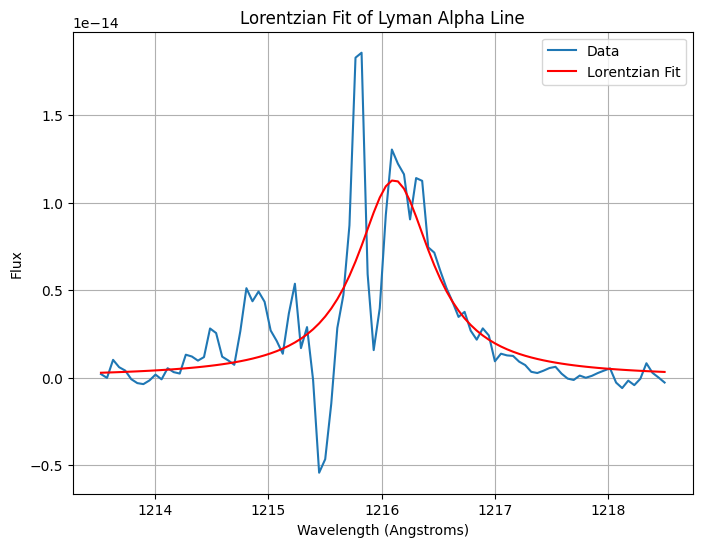

In [59]:

# LORENTZIAN FIT

# Create the Lorentzian fit
lorentzian_model = models.Lorentz1D(amplitude=1.2e-14, x_0=1216.0, fwhm=0.9)  # Initial guesses for amplitude, center, and FWHM
fitter = fitting.LevMarLSQFitter()
best_fit = fitter(lorentzian_model, w[wavelength_mask], f[wavelength_mask])

# Get the parameters of the best-fit Lorentzian model
amplitude_fit = best_fit.amplitude.value
x_0_fit = best_fit.x_0.value
lorentzian_fwhm = best_fit.fwhm.value

print("Best-fit amplitude:", amplitude_fit)
print("Best-fit center:", x_0_fit, "Angstroms")
print("Best-fit FWHM:", lorentzian_fwhm, "Angstroms")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(w[wavelength_mask], f[wavelength_mask], label="Data")
plt.plot(w[wavelength_mask], best_fit(w[wavelength_mask]), color='red', label="Lorentzian Fit")
plt.legend()
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Lorentzian Fit of Lyman Alpha Line')
plt.grid(True)
plt.show()


In [48]:
# Calculate the redshift factor

observed_wavelength = 1238.8743873432861 * u.Angstrom
rest_wavelength = 1238.821 * u.Angstrom

# Calculate redshift factor
z = (observed_wavelength - rest_wavelength) / rest_wavelength

print(f"Redshift factor: {z}")

Redshift factor: 4.309528437619621e-05


In [64]:
# Calculate the FWHM for both models (km/s)
gauss_fwhm_kms = (gauss_fwhm * c / (rest_wavelength * (1 + z))) / 1000
lorentzian_fwhm_kms = (lorentzian_fwhm * c / (rest_wavelength * (1 + z))) / 1000

print(f"FWHM of the Gaussian: {gauss_fwhm_kms.value} km/s")
print(f"FWHM of the Lorentzian: {lorentzian_fwhm_kms.value} km/s")


FWHM of the Gaussian: 220.0249884746944 km/s
FWHM of the Lorentzian: 196.86886425477 km/s
